# Exploratory Data Analysis on a Specific Youtube Channel Using the Youtube API  

### Introduction: 
- This project will be exploring how to use the Youtube API to gain insights.
- It will be looking at one specific youtuber, Jake Tran, and look through his channel stats, videos, views, likes, video duration, etc.
- The project will be also exploring trending topics using NLP techniques.

### Project Steps:

- Obtain video meta data via Youtube API for Jake Tran's channel (this will consist of several smaller steps: create a developer key, request data and transform the responses into a usable data format)
- Prepocess data and engineer additional features for analysis
- Exploratory data analysis
- Conclusions

In [1]:
#import libraries
import os
import googleapiclient.errors
from googleapiclient.discovery import build
import pandas as pd
from http.client import responses
from oauth2client.transport import request
from IPython.display import JSON
from dateutil import parser
import isodate



#data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set(style="darkgrid", color_codes=True)

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leodagraca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leodagraca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Data Creation with Youtube API

The API key was obtained from creating a project on Google Developers Console. Then I was able to acquire Jake Tran's channel ID and configured the credentials function to get the channel statistics.

In [2]:
#keys
API_KEY = 'XXXXXXXXX'
CHANNEL_ID = 'UCoOjH8D2XAgjzQlneM2W0EQ'

#API setup
api_service_name = "youtube"
api_version = "v3"

#Credentials
youtube = build(
        api_service_name, api_version, developerKey=API_KEY)

#### Getting Channel Statistics

In [7]:
"""
    Get channel statistics: title, subscriber count, view count, video count, upload playlist

    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
"""

def get_channel_stats(youtube, CHANNEL_ID):
    
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id= CHANNEL_ID
    )
    response = request.execute()

# loop through items
    for item in response ['items']:
        data = {'channnelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistID': item['contentDetails']['relatedPlaylists']['uploads']
           }
    all_data.append(data)
    
    return(pd.DataFrame(all_data))

In [4]:
#Obtaining channel stats
channel_stats = get_channel_stats(youtube, CHANNEL_ID)
channel_stats

,channnelName,subscribers,views,totalVideos,playlistID
0,Jake Tran,1040000,102659665,169,UUoOjH8D2XAgjzQlneM2W0EQ


In [18]:
"""
Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist

"""

playlist_id = "UUoOjH8D2XAgjzQlneM2W0EQ"

def get_video_ids(youtube, playlist_id):
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [19]:
#Number of videos uploaded 
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

169

#### Getting Video Statistics

In [20]:
"""
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """

def get_video_details(youtube, video_ids):
   
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [21]:
#Obtain video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,bGVhjBob4dY,Jake Tran,None Dare Call It a Conspiracy,Sign up for Extra with our link https://extra....,None,2022-04-19T15:00:16Z,248714,14879,None,1541,PT14M50S,hd,false
1,JRl98kMJPFA,Jake Tran,The Economics of Pirates,Get a 60-day free trial at https://www.shipsta...,None,2022-04-18T20:25:14Z,133804,7436,None,912,PT15M,hd,false
2,_ZjpDgbvjOQ,Jake Tran,Insulin is literally a scam,Try ZipRecruiter for FREE at https://Ziprecrui...,None,2022-04-14T20:22:29Z,273496,18691,None,3425,PT9M58S,hd,false
3,FtWLPqrDoqs,Jake Tran,How to create a ponzi scheme (feat. BitConnect),🎵 Get 100 JAM tokens for free and stream music...,None,2022-04-11T15:00:06Z,213760,9656,None,966,PT14M6S,hd,false
4,AV2u23yurJE,Jake Tran,Putin’s obsession with poisoning people,Use my link https://bit.ly/JakeTranDCMar22 and...,None,2022-04-07T15:00:08Z,309596,14276,None,903,PT11M13S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,HS7937s5SWo,Jake Tran,Why Graham Stephan is killing the YouTube Algo...,😈 Watch exclusive 40+ minute documentaries tha...,"[graham stephan, graham, stephan, the graham s...",2019-09-04T20:15:02Z,244600,17337,None,2957,PT12M34S,hd,false
165,7hpwIjRSraQ,Jake Tran,Exposing the Dark Truth Behind SMMA,😈 Watch exclusive 40+ minute documentaries tha...,"[smma, dan henry, social media marketing, digi...",2019-07-22T20:15:00Z,90086,3966,None,482,PT8M27S,hd,false
166,hExK-sm2-3o,Jake Tran,Working 12 Hours A Day Is Changing My Life,😈 Watch exclusive 40+ minute documentaries tha...,"[4 hour work week, financial freedom, producti...",2019-06-17T20:30:00Z,60766,2303,None,215,PT6M39S,hd,false
167,_pMGt5sahRo,Jake Tran,My SaaS Application FAILED. Here’s 6 Things I ...,😈 Watch exclusive 40+ minute documentaries tha...,"[software as a service, saas application, saas...",2019-03-04T21:30:01Z,53550,1701,None,116,PT16M17S,hd,false


#### Getting Video Comments

In [45]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments) 

In [48]:
#Obtaining comments dataframe
comments_df = pd.DataFrame()
comments_data = get_comments_in_videos(youtube, video_ids)
comments_df = comments_df.append(comments_data, ignore_index=True)
comments_df

,video_id,comments
0,bGVhjBob4dY,[Sign up for Extra with our link https://extra...
1,JRl98kMJPFA,[Get a 60-day free trial at https://www.shipst...
2,_ZjpDgbvjOQ,[Try ZipRecruiter for FREE at https://Ziprecru...
3,FtWLPqrDoqs,[I have the feeling that this video is more ab...
4,AV2u23yurJE,[Use my link https://bit.ly/JakeTranDCMar22 an...
...,...,...
164,HS7937s5SWo,[Watched until the end and I destroyed the lik...
165,7hpwIjRSraQ,[Why are people so mad! You're never going to ...
166,hExK-sm2-3o,"[My next video ""working 3 hours a day is chang..."
167,_pMGt5sahRo,"[Even your least popular video is good, 13:13 ..."


## Data pre-processing & feature engineering


In [22]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [23]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [24]:
#Convert count columns to numeric columns
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors ='coerce', axis = 1)

In [25]:
#Publish day in the week
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [26]:
#Convert duration object into integer of seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] =  video_df['durationSecs'].astype('timedelta64[s]')

In [37]:
#Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [40]:
#Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [27]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,890.0,PT14M50S
1,900.0,PT15M
2,598.0,PT9M58S
3,846.0,PT14M6S
4,673.0,PT11M13S
...,...,...
164,754.0,PT12M34S
165,507.0,PT8M27S
166,399.0,PT6M39S
167,977.0,PT16M17S


In [28]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,bGVhjBob4dY,Jake Tran,None Dare Call It a Conspiracy,Sign up for Extra with our link https://extra....,None,2022-04-19 15:00:16+00:00,248714.0,14879.0,NaN,1541.0,PT14M50S,hd,false,Tuesday,890.0,0
1,JRl98kMJPFA,Jake Tran,The Economics of Pirates,Get a 60-day free trial at https://www.shipsta...,None,2022-04-18 20:25:14+00:00,133804.0,7436.0,NaN,912.0,PT15M,hd,false,Monday,900.0,0
2,_ZjpDgbvjOQ,Jake Tran,Insulin is literally a scam,Try ZipRecruiter for FREE at https://Ziprecrui...,None,2022-04-14 20:22:29+00:00,273496.0,18691.0,NaN,3425.0,PT9M58S,hd,false,Thursday,598.0,0
3,FtWLPqrDoqs,Jake Tran,How to create a ponzi scheme (feat. BitConnect),🎵 Get 100 JAM tokens for free and stream music...,None,2022-04-11 15:00:06+00:00,213760.0,9656.0,NaN,966.0,PT14M6S,hd,false,Monday,846.0,0
4,AV2u23yurJE,Jake Tran,Putin’s obsession with poisoning people,Use my link https://bit.ly/JakeTranDCMar22 and...,None,2022-04-07 15:00:08+00:00,309596.0,14276.0,NaN,903.0,PT11M13S,hd,false,Thursday,673.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,HS7937s5SWo,Jake Tran,Why Graham Stephan is killing the YouTube Algo...,😈 Watch exclusive 40+ minute documentaries tha...,"[graham stephan, graham, stephan, the graham s...",2019-09-04 20:15:02+00:00,244600.0,17337.0,NaN,2957.0,PT12M34S,hd,false,Wednesday,754.0,24
165,7hpwIjRSraQ,Jake Tran,Exposing the Dark Truth Behind SMMA,😈 Watch exclusive 40+ minute documentaries tha...,"[smma, dan henry, social media marketing, digi...",2019-07-22 20:15:00+00:00,90086.0,3966.0,NaN,482.0,PT8M27S,hd,false,Monday,507.0,23
166,hExK-sm2-3o,Jake Tran,Working 12 Hours A Day Is Changing My Life,😈 Watch exclusive 40+ minute documentaries tha...,"[4 hour work week, financial freedom, producti...",2019-06-17 20:30:00+00:00,60766.0,2303.0,NaN,215.0,PT6M39S,hd,false,Monday,399.0,26
167,_pMGt5sahRo,Jake Tran,My SaaS Application FAILED. Here’s 6 Things I ...,😈 Watch exclusive 40+ minute documentaries tha...,"[software as a service, saas application, saas...",2019-03-04 21:30:01+00:00,53550.0,1701.0,NaN,116.0,PT16M17S,hd,false,Monday,977.0,21


## EDA

## Best Performing videos

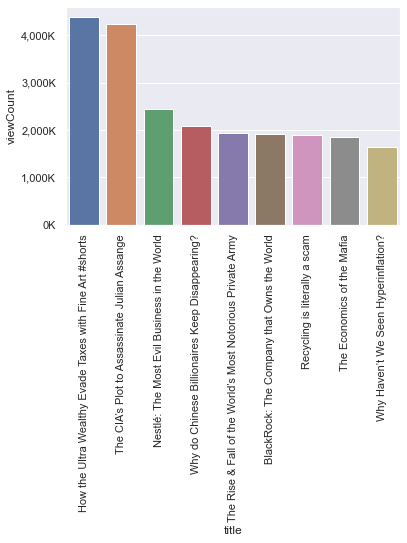

In [29]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

#### Observations: 

Here we can see that Jake Tran's top two videos have just over 4 million views. His other top videos fall just above and below the 2 million view mark.

## View Distribution per Video

/Users/leodagraca/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

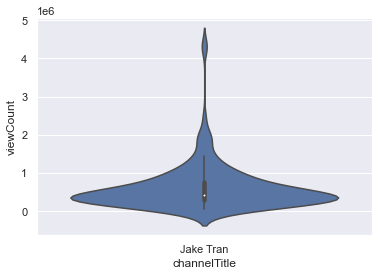

In [30]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

#### Observations: 

The distribution here tells us that most of his videos lie around the 1 million view mark. He has had videos that have surpassed that mark on certain occasions but for the most part he can expect to do about 500k - 1 million views per video released. 

## Views vs. likes and comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

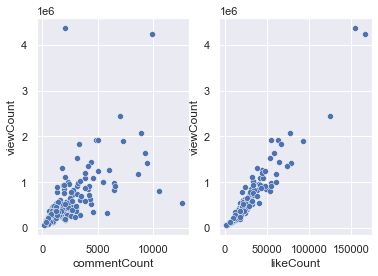

In [31]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

#### Observations: 

The plots below show the correlation between views and likes/comments. It is evident that there is a positive correlation as the more views Jake gets on his videos the more likes and comments he receives. There is a stronger correlation when it comes to likes than comments. This is to be expected as the more viewers that tune into the uploads the more likes he will expect to get.

## Video Duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

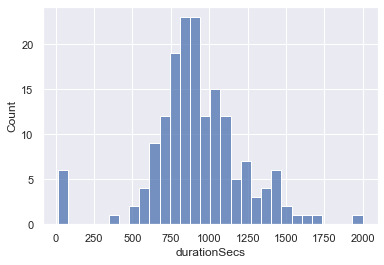

In [32]:
sns.histplot(data = video_df, x ='durationSecs', bins = 30)

<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

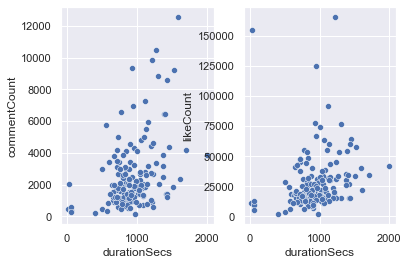

In [33]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

#### Observations: 

- The histogram above has a normal distribution shape to it. It also displays that approximately 50 of his videos have a a duration length of about 800 secs or 13 minutes.
- The duration was plotted against comments and likes to view their respective relationships. The plots do not display much of a realtionship. We can see that much of distribution for both comments and likes lies around the 1000 secs mark but more inquiries would have to be made to come up with clear insights.

## Does title length matter for views?

<AxesSubplot:xlabel='titleLength', ylabel='viewCount'>

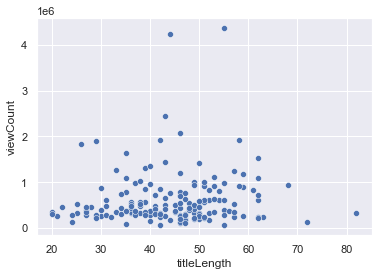

In [38]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

#### Observations: 

The plot above shows that there is not a clear relationship between title length and the amount of video views.

## Number of tags vs views

<AxesSubplot:xlabel='tagsCount', ylabel='viewCount'>

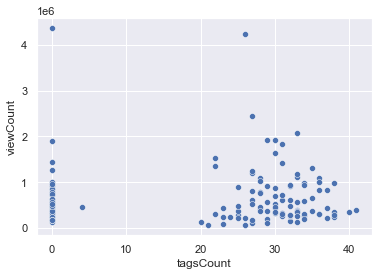

In [41]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

#### Observations: 

The number of tags used by Jake Tran are either 0 or lie between 20-40. Here it looks that he uses 0 tags a lot and that garners similar amount of views when 20-40 tags are used.

## Wordcloud for video titles

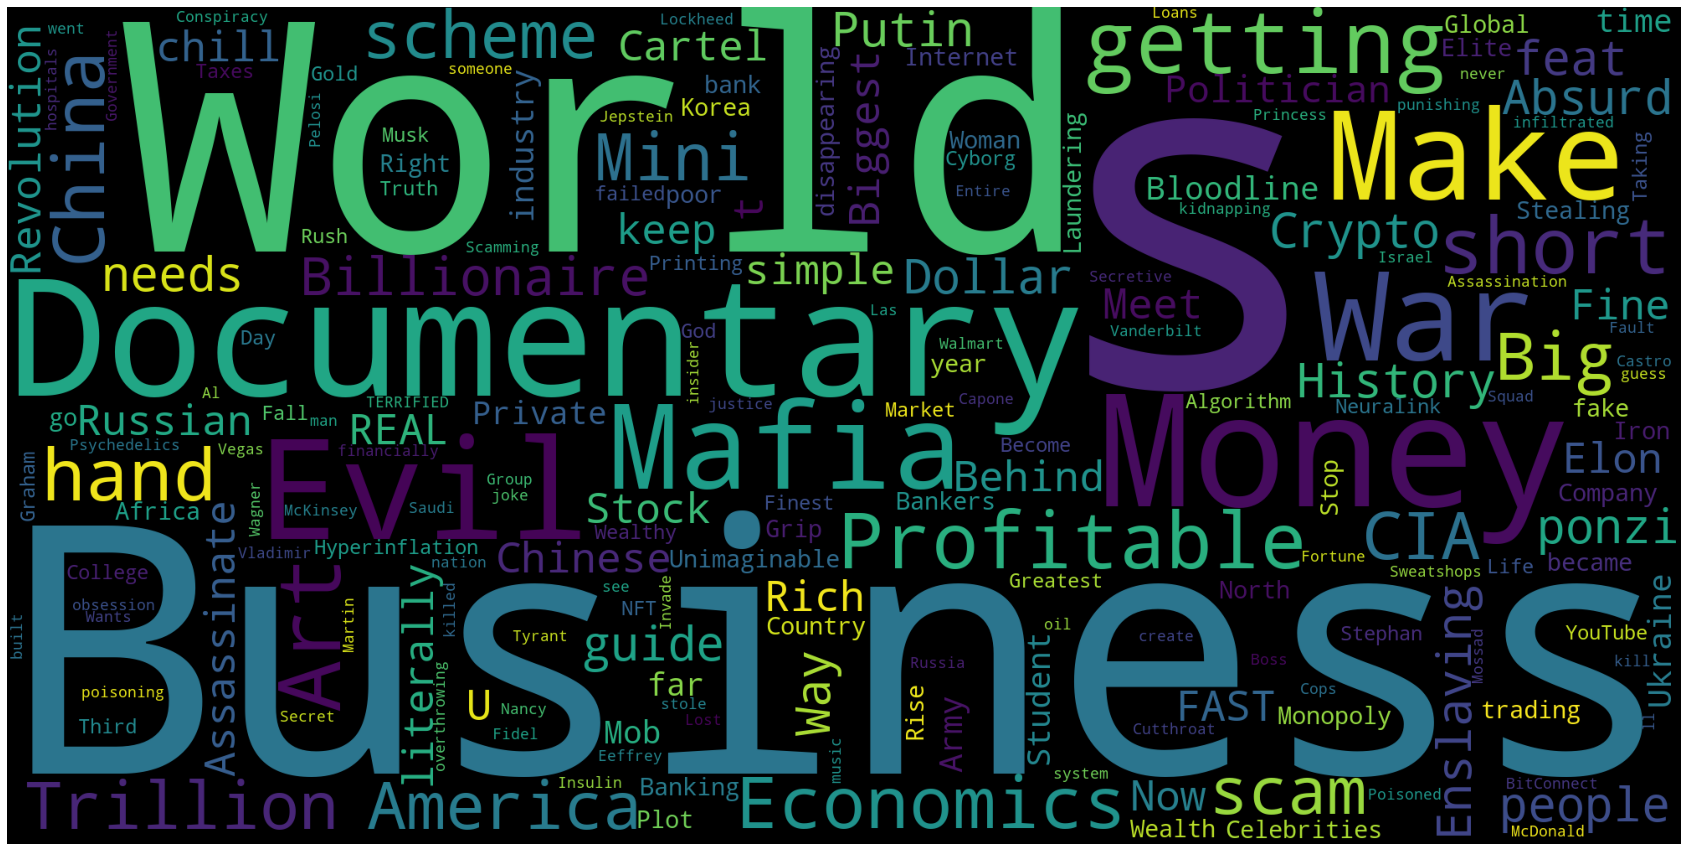

In [58]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

#### Observations: 

Here is a wordcloud for video titles where the stopwords such as "you", "I", "the", etc. were removed. The most common words used are "Business", "World", and "Documentary". These words are to be expected as the videos being produced deal with these topics.

## Wordcloud for video comments

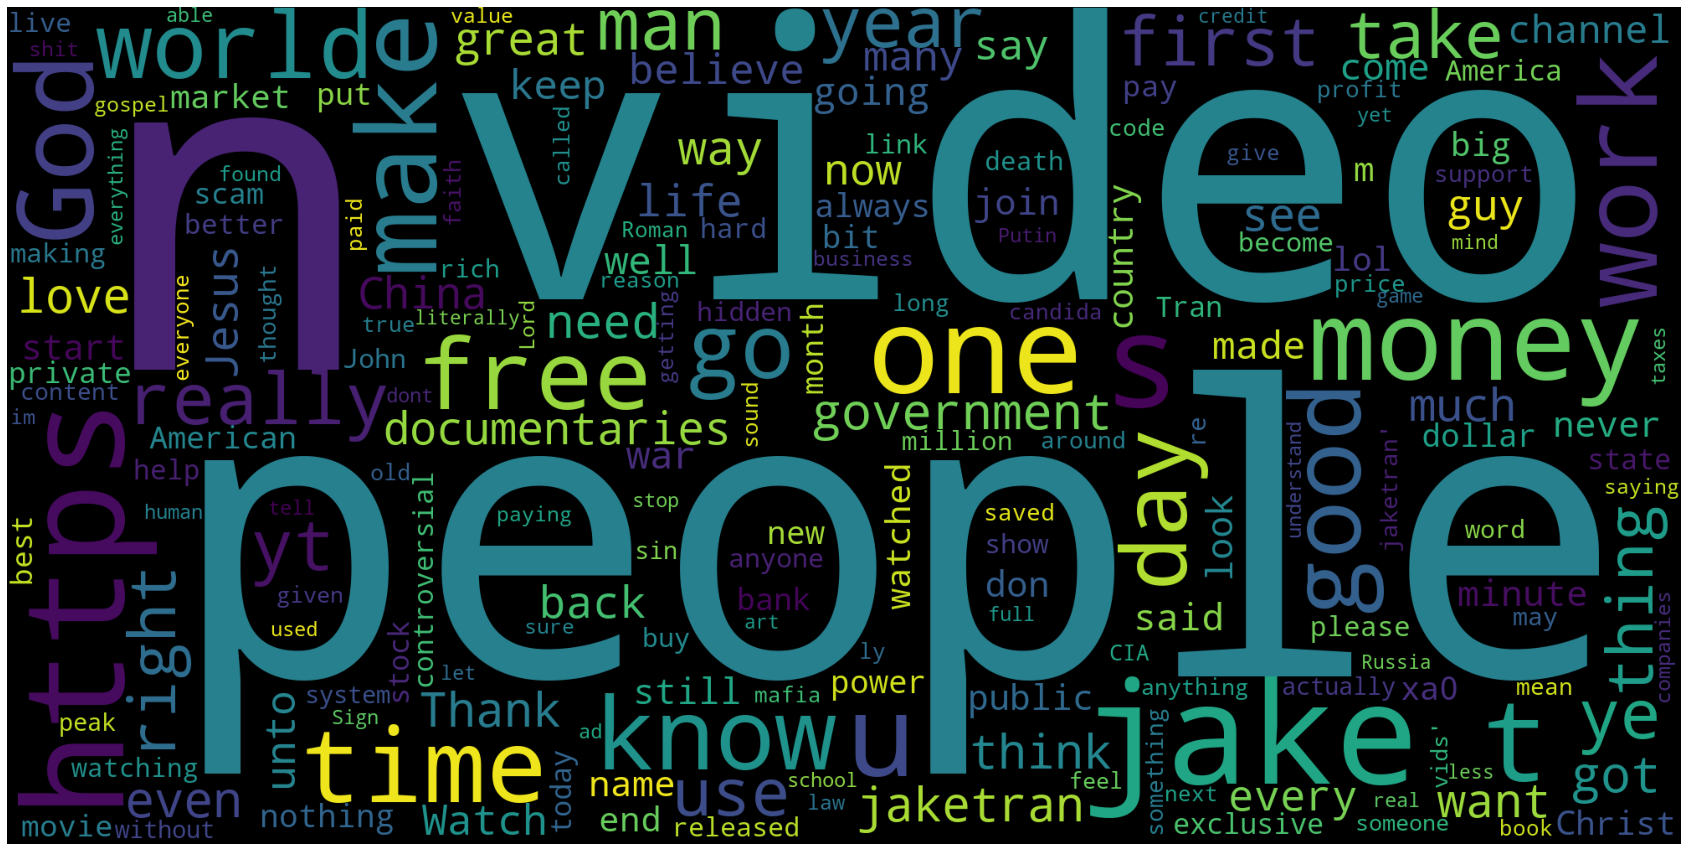

In [52]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off")
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

#### Observations: 

A wordcloud was also configured for video comments. Here we can see that "video" and "people" are the most frequent words in the comments.

## Upload Schedule

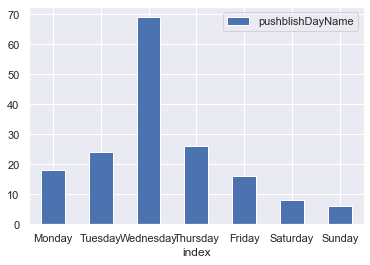

In [59]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

#### Observations: 

The bar graph above shows the days Jake has uploaded his videos. He has a preference to upload his videos on Wednesday with about 70 of his 169 videos published on that day. He rarely uploads any videos on Saturday or Sunday.

## Conclusions:

This project has given good insight of the statistics of Jake Tran's youtube channel. This a channel I find myself watching relatively frequently and it was interesting to come up with the findings I did.

- His top two videos had over 4 million views with his top video being "How the Ultra Wealthy Evade Taxes with Fine Art". His other top videos fall just above and below the 2 million view mark.
- When uploading his videos he can expect to see about 500k - 1 million views with a few videos doing better than that mark.
- There is a strong relationship when it comes to views and likes. Jake receives appreciation from his viewers in his more watched videos in the form of likes. He can look to these videos that performed well to plan future videos.
- Approximately 50 of his videos have a a duration length of about 800 secs or 13 minutes.
- The number of tags used by Jake Tran are either 0 or lie between 20-40. He uses 0 tags a lot which gains an equivalent amount of views to 20-40 tags.
- He has a preference to upload his videos on Wednesday and rarely uploads any videos on Saturday or Sunday.

## References/Resources Used:

[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Converting video durations to time function. https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3

[3] P. Covington, J. Adams, E. Sargin. The youtube video recommendation system. In Proceedings of the Fourth ACM Conference on Recommender Systems, RecSys '16, pages 191-198, New York, NY, USA, 2016. ACM.

[4] Thu Vu analytics. https://www.youtube.com/watch?v=D56_Cx36oGY. https://github.com/thu-vu92/youtube-api-analysis/blob/main/Sample_project_youtube_videos_EDA.ipynb